<a href="https://colab.research.google.com/github/talmoroc/ROME-and-PCS-NLP-Project/blob/main/db-creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data upload

In [1]:
import zipfile, requests
from io import BytesIO
from io import StringIO

zip_url = 'https://www.data.gouv.fr/fr/datasets/r/9ed5d77e-180f-4358-909c-91d64f277a49'
r = requests.get(zip_url)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall("/content/fiches_metier")

# Preprocessing of the data

### Packages for pdf processing

In [2]:
# Package not directly available in Colab
!pip install pdfminer

In [3]:
# Layout analysis
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfdocument import PDFDocument
from pdfminer.layout import LAParams

# Parsing
from pdfminer.pdfparser import PDFParser
import argparse

# Encoding to string
from pdfminer.converter import TextConverter
from io import StringIO 
print("done")

done


### Converting PDF to text

In [223]:
# Custom functions that convert the pdf to a structured string list

def convert_pdf_to_string(file_path):

	output_string = StringIO()
	with open(file_path, 'rb') as in_file:
	    parser = PDFParser(in_file)
	    doc = PDFDocument(parser)
	    rsrcmgr = PDFResourceManager()
	    device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
	    interpreter = PDFPageInterpreter(rsrcmgr, device)
	    for page in PDFPage.create_pages(doc):
	        interpreter.process_page(page)

	return(output_string.getvalue())

### Processing of the text

In [224]:
import numpy as np
import pandas as pd
import random
import re
from collections import Counter

In [235]:
def text_cleaning(raw, split, parasites):
  clean = raw.split(split)
  for p in parasites :
    clean = list(filter(lambda a: a != p, clean))
  return clean

def paging(skill_clean, ref):
  pages=[]
  i_pages = [-1]+[i for i,x in enumerate(skill_clean) if x in ['1/','2/','3/','4/','5/','6/','7/','8/','9/','0/']]
  for i in range(len(i_pages)-1):
    pages.append(skill_clean[i_pages[i]+1:i_pages[i+1]])
  return pages

def clean(page,ref):
  to_remove=[]
  for s in page:
    if re.match('^[A-Za-z]{1,2}$', s) != None:
      to_remove.append(s)
  clean_page = [x for x in page if x not in to_remove]
  return clean_page

In [243]:
def skills_extraction(pages,ref):
  skills_dict = {'Skills':[],
               'Environnements de travail':[],
               'Mobilité professionnelle':[]}

  def category(x):
    category_regexp = '.*v [ ]+(.*)'
    category_regexp_envt = '(Structures)|(Secteurs)|(Conditions)'
    subcategory_regexp = '.*(Savoir-faire)$|.*(Savoirs)$|.*(Environnements de travail)'
    test_cat = re.match(category_regexp, x)
    test_cat_envt = re.match(category_regexp_envt, x)
    test_subcat = re.match(subcategory_regexp, x)
    if test_cat_envt !=None:
      return 'Environnements de travail'
    elif test_cat != None and test_cat[1] == 'Mobilité professionnelle':
      return test_cat[1]
    elif test_cat != None and test_cat[1] != 'Environnements de travail':
      return 'Skills'
    elif test_subcat !=None:
      return 'Subcategory'
    else:
      return False

  for p in pages:
    clean_page = clean(p, ref)
    current_category = "Skills"
    for element in clean_page:
      cat = category(element)
      if cat not in (False, 'Subcategory'):
        current_category = cat
      elif not cat:
        if current_category == 'Mobilité professionnelle':
          if re.match('^o ', element) != None:
            skills_dict['Environnements de travail'].append(element.strip('o '))
          else:
            skills_dict[current_category].append(element)
        elif re.match('^o ', element) != None:
          skills_dict[current_category].append(element.strip('o '))
        else:
          skills_dict[current_category][-1] += " "+element

  return skills_dict

In [244]:
def get_info_header(header):
  appellations = re.findall('o  [ ]*(.*)',header)
  stripped_header = re.sub('o  [ ]*(.*)','',header)
  title = re.findall('[A-Z][0-9]{4} - (.*)', stripped_header)[0]
  stripped_header = stripped_header.replace('\n','')
  definitions = re.findall("Définition(.*)Accès à l\'emploi métier",stripped_header)[0]
  access = re.findall("Accès à l'emploi métier(.*)Conditions d\'exercice de l\'activité",stripped_header)[0]
  conditions = re.findall("Conditions d\'exercice de l\'activité(.*)",stripped_header)[0]

  return title, appellations, definitions, access, conditions


In [245]:
def get_info_skills(skills, ref):
  parasites = ['','Toutes les appellations', '-', 'Pôle emploi - Direction Générale','v  Environnements de travail',
              "© Copyright 2021 Pôle Emploi. Reproduction et diffusion interdites sans l'accord de Pôle emploi",
              'Mars 2021', 'n','Fiche ROME', 'Fiches ROME proches','Emplois / Métiers proches',
              'Emplois / Métiers envisageables si évolution', 'Fiches ROME envisageables si évolution','Fiche ROME '+ref]
  skill_clean  = text_cleaning(skills, '\n', parasites)
  pages = paging(skill_clean, ref)
  skills_dict = skills_extraction(pages, ref)
  return skills_dict['Skills'], skills_dict['Environnements de travail'], skills_dict['Mobilité professionnelle']

In [255]:
def features_extraction(ref):
  info_dictionary = {}

  # Extracting the raw file
  raw = convert_pdf_to_string(f'/content/fiches_metier/{ref}.pdf')

  # Splitting the file into two parts
  header, skills = raw.split('v  Compétences de base',1)
  skills = 'v  Compétences de base'+skills
  
  # Extracting info from the first part of the file
  info_dictionary['Title'], info_dictionary['Appellations'], info_dictionary['Definition'], info_dictionary['Accessibility'], info_dictionary['Working Conditions'] = get_info_header(header)

  # Extracting info from the second part of the file
  skills, working_environment, mobility = get_info_skills(skills, ref)
  info_dictionary['Skills'] = skills
  info_dictionary['Environment'] = working_environment
  codes_mobility = [re.match('[A-Z][0-9]{4}', m)[0] for m in mobility if re.match('[A-Z][0-9]{4}', m)!=None]
  info_dictionary['Mobility'] = list(dict.fromkeys(codes_mobility))

  return info_dictionary



## Retrieving information from all occupation files

In [247]:
import os

In [248]:
# List of the references of fiches métiers

ref_list = [fiche.strip('.pdf') for fiche in os.listdir('/content/fiches_metier') if fiche != '.ipynb_checkpoints']
print(f'Occupation files : {ref_list[:5]}...')
print(f'Total number : {len(ref_list)}')

Occupation files : ['E1107', 'K1205', 'B1303', 'K1202', 'D1507']...
Total number : 532


In [256]:
# Dictionary of all the information about occupations

occupation_dictionary = dict([(ref, features_extraction(ref)) for ref in ref_list])

In [33]:
# Looking at the mobility information

rf = random.choice(ref_list)
print(rf, occupation_dictionary[rf]['Title'])
print(occupation_dictionary[rf]['Mobility'])
print([occupation_dictionary.get(m)['Title'] for m in occupation_dictionary[rf]['Mobility']])

L1502 Costume et habillage spectacle
Counter({'L1502': 5, 'B1801': 1, 'B1803': 1, 'B1805': 1, 'D1206': 1, 'H1205': 1})
['Costume et habillage spectacle', "Réalisation d'articles de chapellerie", 'Réalisation de vêtements sur mesure ou en petite série', 'Stylisme', "Réparation d'articles en cuir et matériaux souples", 'Études - modèles en industrie des matériaux souples']


Nombre de caractères moyen d'un skill : 43.787511537119094
Total de caractères :  1155307
Répartition des nombres de skills par fiche métier :


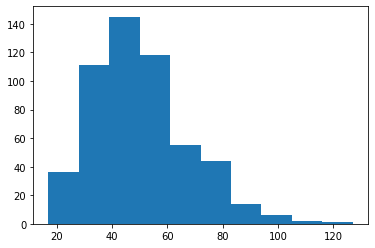

In [259]:
print("Nombre de caractères moyen d'un skill :", np.mean([np.mean([len(skill) for skill in occupation_dictionary[ref]['Skills']]) for ref in ref_list]))
print("Total de caractères : ", np.sum([np.sum([len(skill) for skill in occupation_dictionary[ref]['Skills']]) for ref in ref_list]))
print("Répartition des nombres de skills par fiche métier :")

import matplotlib.pyplot as plt
plt.hist([len(occupation_dictionary[ref]['Skills']) for ref in ref_list]);
# Nombre de caractères moyen d'un skill : 41.71413728527632
# Total de caractères :  1145833
# Répartition des nombres de skills par fiche métier :

# Base de classification des métiers

In [ ]:
# importation de la base d'équivalence FAP-PCS-ROME
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
convertPCS_ROME = pandas.read_excel("/content/drive/MyDrive/NLP Project/Fichier ROME-PCS au propre.xls")
convertPCS = pandas.read_excel("/content/drive/MyDrive/NLP Project/PCS classification 2.xls")

In [ ]:
# but : convertir les catégories 3 de PCS en catégorie 2
# comment on s'y prend : on a le code de la PCS dans la base PCS-ROME. 
# Les deux premiers chiffres de la PCS dans la classfication de niveau 3 correspondent à la PCS de classification niveau 2.
# Exception : pour les agriculteurs, où la PCS commence juste avec le 1.

# récupération dans la base ROME des deux premiers caractères


# matching avec la conversion catégorie 2/ catégore 3 de l'INSEE pour obtenir la classification de type 2.
convertPCS_ROME["PCS niveau 2"] = convertPCS_ROME["PCS"]
convertPCS_ROME["PCS niveau 2"] =  convertPCS_ROME["PCS niveau 2"].map(lambda x: x[0:2])

Comme le code agriculteur dans la classification 2 est 10 et non pas 11, 12, 13, on va recoder cette information avant de faire un merging.

In [ ]:
convertPCS_ROME["PCS niveau 2"] =  convertPCS_ROME["PCS niveau 2"].map(lambda x: str(x).replace("11",'10'))
convertPCS_ROME["PCS niveau 2"] =  convertPCS_ROME["PCS niveau 2"].map(lambda x: str(x).replace("12",'10'))
convertPCS_ROME["PCS niveau 2"] =  convertPCS_ROME["PCS niveau 2"].map(lambda x: str(x).replace("13",'10'))

In [ ]:
# on fait en sorte que les catégories de la table de conversion d'une PCS à 
#une autre et d'une PCS à une ROME est une colonne commune avec le même type
convertPCS["Code"] = convertPCS["Code"].astype(str)
# on peut merger
convertPCS_ROME = pandas.merge(convertPCS, convertPCS_ROME, left_on = "Code", right_on = "PCS niveau 2")

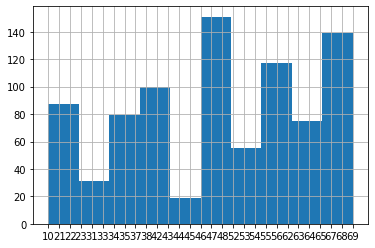

In [ ]:
# on observe un peu les données pour voir si elles sont bien regroupés
convertPCS_ROME["Code"].hist()
# il semblerait que les catégories du type 20 et 40 ne sont pas très nombreuses, (voir si c'est cohérent aussi)
# pour éviter des problèmes, on peut les regrouper



In [ ]:
convertPCS_ROME["Code"] =  convertPCS_ROME["Code"].map(lambda x: str(x).replace("11",'10'))



In [ ]:
# arborescence ROME

# voir combien de fiche ROME par PCS
# dans le dictionnaire :
# titre de la fiche
# les appelations
# la définition
# l'accessibilité (diplôme)
# condition de travail
# connaissance de base
# savoir faire
# environnement de travail


In [ ]:
# PREPROCESSING

# TOKENISATION
# LEMMATIZATION
# POS TAGGING NER

In [ ]:
# BONUS ANALYTIQUES
# Inclure les diplômes ou pas => voir si les PCS sont liées au diplôme
# Voir la cohérence entre les prédictions et le réseau de mobilité professionnelle

In [ ]:
# MODELES

# Solution bourrin à tester en premier : tout concaténer et faire tourner un modèle NLP (BERT ou LSTM si ça marche pas, ou si on arrive à tester ça vite)
# ==> mécanismes d'attention.

# Combiner deux modèles sur les 2 sous-ensembles de données ?
# ==> Comparaison possible et moyenne des probabilités
# Modèle sur les skills: faire un modèle de ML classique? Random Forest?

# Faire un réseau de neurone qui s'applique spécialement à des phrases courtes au lieu de l'algo de ML ?
# Trouver un modèle qui traite l'ensemble des données — paramétrisation qui permettre de traduire la disparité des données